In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kneed.knee_locator import KneeLocator

In [2]:
df = pd.read_csv('data/adult19.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 130.4+ MB


In [4]:
# those that feel depressed at least on a weekly basis
df_depressed = df[df.DEPFREQ_A <= 2].copy()

In [5]:
df_depressed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 12.7+ MB


In [6]:
depressed_vars = pd.read_csv('dep_vars.csv')

In [7]:
depressed_core = df_depressed[depressed_vars.Variable].copy()

In [8]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DEPEV_A     3118 non-null   int64  
 1   DEPFREQ_A   3118 non-null   int64  
 2   DEPMED_A    3118 non-null   int64  
 3   DEPLEVEL_A  3118 non-null   float64
 4   PHQ81_A     3118 non-null   int64  
 5   PHQ82_A     3118 non-null   int64  
 6   PHQ83_A     3118 non-null   int64  
 7   PHQ84_A     3118 non-null   int64  
 8   PHQ85_A     3118 non-null   int64  
 9   PHQ86_A     3118 non-null   int64  
 10  PHQ87_A     3118 non-null   int64  
 11  PHQ88_A     3118 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 316.7 KB


In [9]:
depressed_core.columns

Index(['DEPEV_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'PHQ81_A', 'PHQ82_A',
       'PHQ83_A', 'PHQ84_A', 'PHQ85_A', 'PHQ86_A', 'PHQ87_A', 'PHQ88_A'],
      dtype='object')

According to the codebook, DEPEV_A is the response to the question: "Have you ever been told by a doctor or health professional that you had ...any type of depression?" The values DEPEV_A can take are: 1, yes; 2, no, 7, refused; 8, not ascertained; and 9 , don't know.  Labeling the values and then creating a countplot...  

<AxesSubplot:xlabel='DEPEV_A', ylabel='count'>

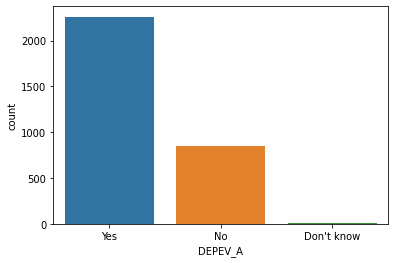

In [10]:
labels = {1:'Yes', 2: 'No', 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
depressed_core.DEPEV_A.replace(labels, inplace=True)
sns.countplot(x = 'DEPEV_A', data = depressed_core)

The majority have been diagnosed as depressed although over 500 have not been told by a doctor they have depression.  To reduce the number of columns when one hot encoding, I'm going to replace yes with 1, no with -1, and don't know with 0


In [11]:
labels = {'Yes':1,'No':-1,"Don't know":0}
depressed_core.DEPEV_A.replace(labels, inplace=True)

DEPFREQ_A is the response to the question "How often do you feel depressed?" The values DEPFREQ_A can take are: 1, daily; 2, weekly; 3, monthly; 4, a few times a year; 5 never; 7, refused; 8, not ascertained; 9, don't know.  Earlier I filtered the dataframe to only include values of 1 or 2.  Renaming the labels and creating a countplot... 

<AxesSubplot:xlabel='DEPFREQ_A', ylabel='count'>

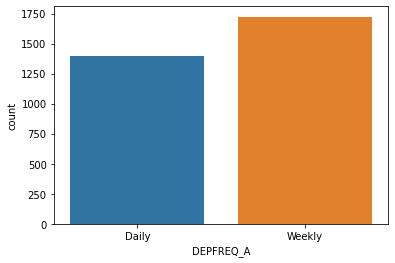

In [12]:
labels = {1:'Daily',2:'Weekly'}
depressed_core.DEPFREQ_A.replace(labels,inplace=True)
sns.countplot(x='DEPFREQ_A', data=depressed_core)

As you can see more feel depression on a weekly basis but it close to even.

DEPMED_A represents respondants to the question, "Do you take prescription medication for depression?"  The values are: 1, yes; 2, no; 7, refused; 8, not ascertained; and 9, don't know.

<AxesSubplot:xlabel='DEPMED_A', ylabel='count'>

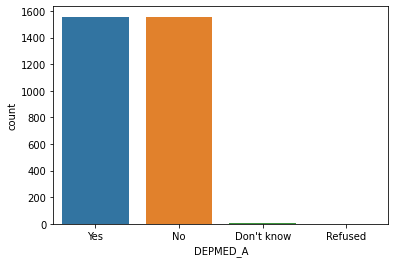

In [13]:
labels = {1:'Yes',2:'No',7:'Refused',8:'Not ascertained',9:"Don't know"}
depressed_core.DEPMED_A.replace(labels,inplace=True)
sns.countplot(x='DEPMED_A',data=depressed_core)

An equal amount of those feeling depression take and do not take medication for depression.  
I am going to combine 'Don't know' and Refused into an 'Other' category.  Then I will set 'yes' to 1, 'no' to -1 and 'other' to 0 to reduce the number of features when the data gets one hot encoded.

In [14]:
labels = {"Don't know":'Other','Refused':'Other'}
depressed_core.DEPMED_A.replace(labels,inplace=True)
labels = {'Yes':1,'No':-1,'Other':0}
depressed_core.DEPMED_A.replace(labels,inplace=True)

DEPLEVEL_A is the respondants answer to the question, "Thinking about the last time you felt depressed, how depressed did you feel?  Would you say a little, a lot, or somewhere in between?".  Values represented: 1, a little; 2, a lot; 3, somewhere in between a little and a lot; 7, refused; 8, not ascertained; 9, don't know. 

<AxesSubplot:xlabel='DEPLEVEL_A', ylabel='count'>

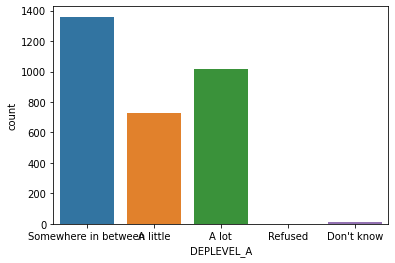

In [15]:
labels = {1: 'A little', 2: 'A lot', 3: 'Somewhere in between', 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
depressed_core.DEPLEVEL_A.replace(labels, inplace=True)
sns.countplot(x = 'DEPLEVEL_A', data = depressed_core)

The majority feel somewhere in between a little and a lot. 
Again I am going to combine refused and Don't know into an other category

In [16]:
labels = {'Refused':"Other","Don't know":"Other"}
depressed_core.DEPLEVEL_A.replace(labels, inplace=True)


PHQ81_A holds responses from the question, "Over the last two weeks how often have you been bothered by little interest or pleasure in doing things?" Responses include: 1, not at all; 2, several days; 3, more than half the days; 4, nearly every day; 7, refused; 8, not ascertained; 9, don't know.

<AxesSubplot:xlabel='PHQ81_A', ylabel='count'>

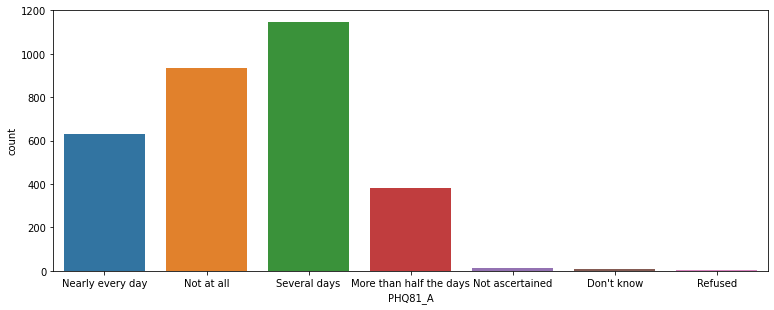

In [17]:
labels = {1: 'Not at all', 2: 'Several days', 3: 'More than half the days', 4: 'Nearly every day', 7: 'Refused', 
          8: 'Not ascertained', 9: "Don't know"}
depressed_core.PHQ81_A.replace(labels, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ81_A', data=depressed_core)

The majority of those facing depression feels bothered by little interest or pleasure several days. I am going to combine Not ascertained, don't know and refused into an other category 

In [18]:
labels_other = {"Don't know":'Other',"Refused":'Other',"Not ascertained":'Other'}
depressed_core.PHQ81_A.replace(labels_other, inplace=True)

PHQ82_A holds the answer to: in the past two weeks, how often have you been bothered by feeling down, depressed or hopeless?
The data can take on values: 1, not at all; 2, several days; 3, more than half the days; 4, nearly every day; 7, refused; 8, not ascertained; or 9, don't know.

<AxesSubplot:xlabel='PHQ82_A', ylabel='count'>

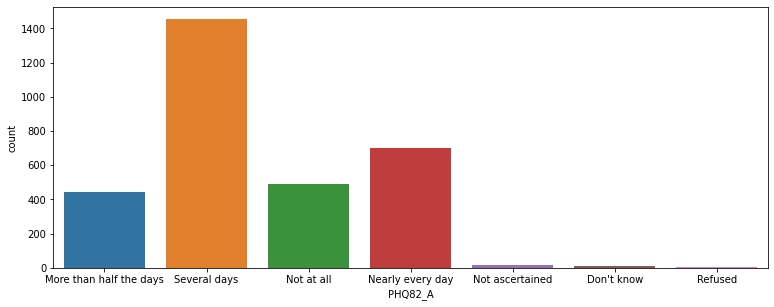

In [19]:
labels_ntostr = {1: 'Not at all', 2: 'Several days', 3: 'More than half the days', 4: 'Nearly every day', 7: 'Refused', 
          8: 'Not ascertained', 9: "Don't know"}
depressed_core.PHQ82_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ82_A', data=depressed_core)


Again most felt down several days.  And again, those will a small amount of values, I am placing in one bucket, 'other'

In [20]:
depressed_core.PHQ82_A.replace(labels_other, inplace=True)

PHQ83_A indicates how often in the past two weeks people have been bothered by trouble falling asleep, trouble staying aslepp, or sleeping too much.

<AxesSubplot:xlabel='PHQ83_A', ylabel='count'>

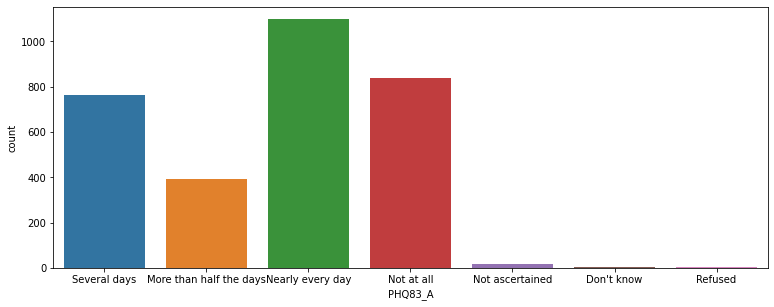

In [21]:
depressed_core.PHQ83_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ83_A', data=depressed_core)

In this case the majority of those with depression have been feeling bothered by trouble with sleep nearly every day

In [22]:
depressed_core.PHQ83_A.replace(labels_other, inplace=True)

PHQ84_A records responses to the question on over the past two weeks how often have you been bothered by feeling tired or having little energy.

<AxesSubplot:xlabel='PHQ84_A', ylabel='count'>

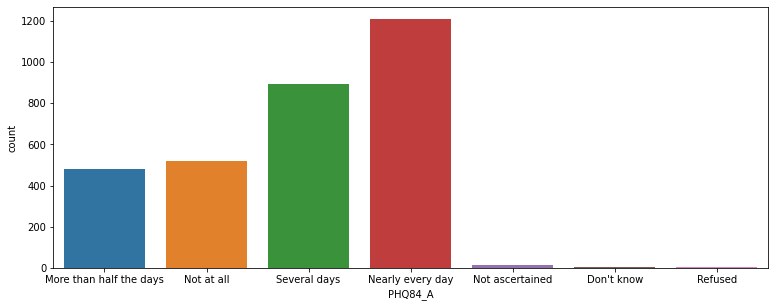

In [23]:
depressed_core.PHQ84_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ84_A', data=depressed_core)


Notice most have trouble with energy levels nearly every day.



In [24]:
depressed_core.PHQ84_A.replace(labels_other, inplace=True)

PHQ85_A reports how many times in the past two weeks have people been bothered by a poor appetite or overeating.

<AxesSubplot:xlabel='PHQ85_A', ylabel='count'>

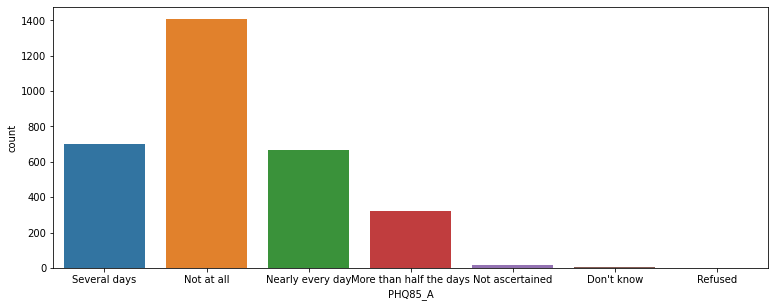

In [25]:
depressed_core.PHQ85_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ85_A', data=depressed_core)

The majority were not at all bothered by over or under eating.



In [26]:
depressed_core.PHQ85_A.replace(labels_other, inplace=True)

PHQ86_A reports how many times over the past two weeks, people have been bothered by feeling bad about themselves.

<AxesSubplot:xlabel='PHQ86_A', ylabel='count'>

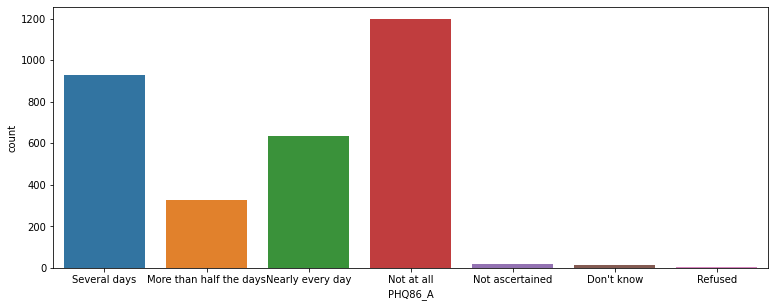

In [27]:
depressed_core.PHQ86_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ86_A', data=depressed_core)

As can be seen there is a split between several days or not at all.



In [28]:
depressed_core.PHQ86_A.replace(labels_other, inplace=True)

PHQ87_A reports how many times over the past few weeks people have been bothered by trouble concentrating

<AxesSubplot:xlabel='PHQ87_A', ylabel='count'>

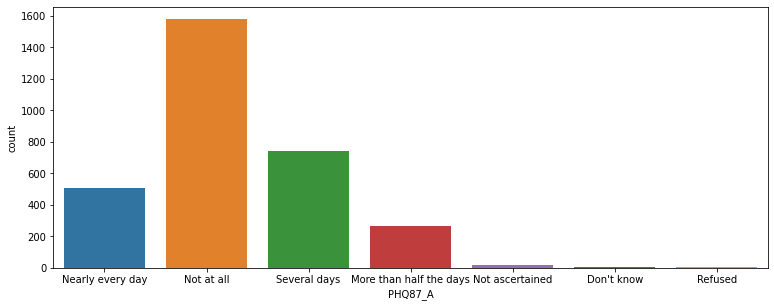

In [29]:
depressed_core.PHQ87_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ87_A', data=depressed_core)

Most were not bothered by trouble concentrating



In [30]:
depressed_core.PHQ87_A.replace(labels_other, inplace=True)

PHQ88_A asks how often in the past few weeks people were bothered by moving or speaking slow or fast.

<AxesSubplot:xlabel='PHQ88_A', ylabel='count'>

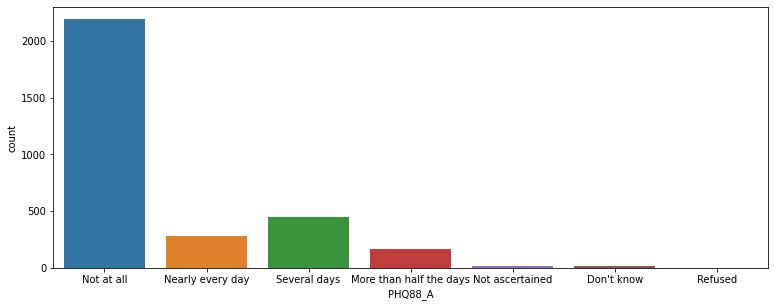

In [31]:
depressed_core.PHQ88_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ88_A', data=depressed_core)

The clear majority is not at all.  Because of this I'm going to drop PHQ88_A

In [32]:
depressed_core.drop('PHQ88_A',axis=1, inplace=True)

In [33]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DEPEV_A     3118 non-null   int64 
 1   DEPFREQ_A   3118 non-null   object
 2   DEPMED_A    3118 non-null   int64 
 3   DEPLEVEL_A  3118 non-null   object
 4   PHQ81_A     3118 non-null   object
 5   PHQ82_A     3118 non-null   object
 6   PHQ83_A     3118 non-null   object
 7   PHQ84_A     3118 non-null   object
 8   PHQ85_A     3118 non-null   object
 9   PHQ86_A     3118 non-null   object
 10  PHQ87_A     3118 non-null   object
dtypes: int64(2), object(9)
memory usage: 356.9+ KB


In [34]:
df_depressed_core = pd.get_dummies(depressed_core)
df_depressed_core.shape

(3118, 43)

# Checking for correlated features 

When calculating distance the features that are very similar are going to be weighted more.

<AxesSubplot:>

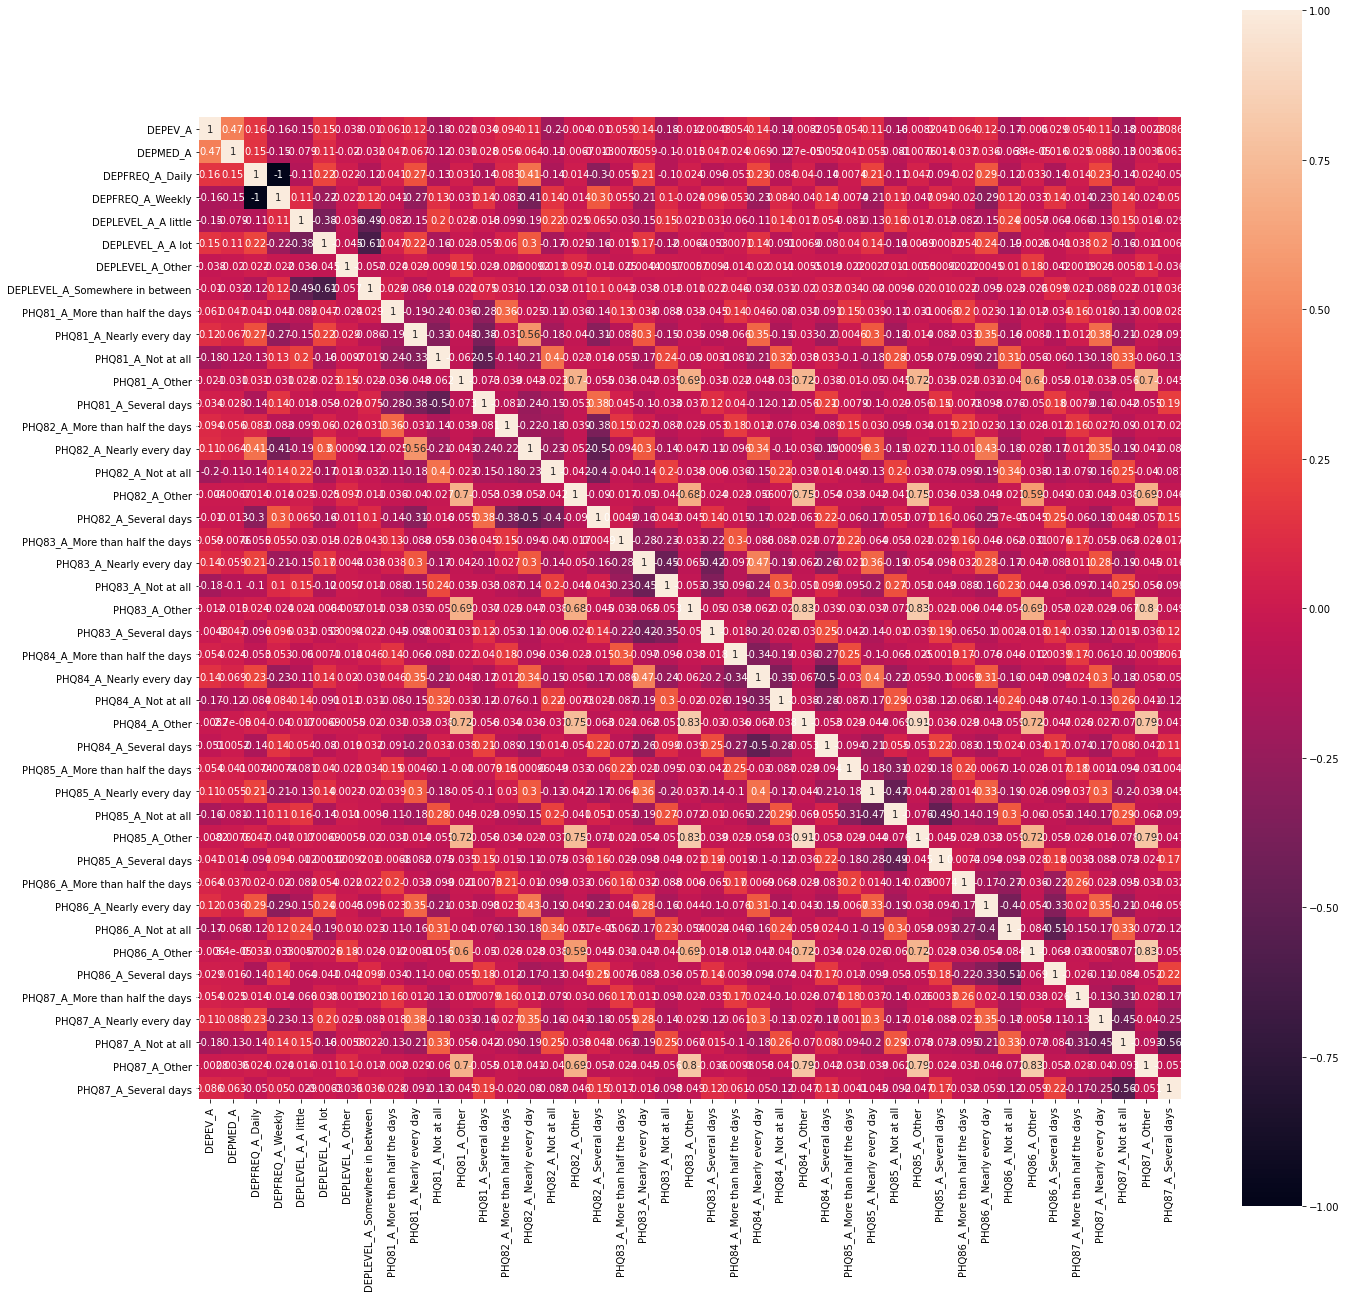

In [35]:
plt.figure(figsize=(22, 22))
sns.heatmap(df_depressed_core.corr(),square=True,annot=True)

As can be seen there is some stronger correlation between the other values of the phq question.  Because of this, I am going to drop these columns.  Most of the other values were small in number anyways.

In [36]:
others = ['PHQ81_A_Other','PHQ82_A_Other','PHQ83_A_Other', 'PHQ84_A_Other','PHQ85_A_Other','PHQ86_A_Other','PHQ87_A_Other']
df_depressed_core.drop(others,axis=1, inplace=True)

#  Visualizing the data using PCA and UMAP

In [37]:
X = df_depressed_core.values

Text(0.5, 1.0, 'UMAP')

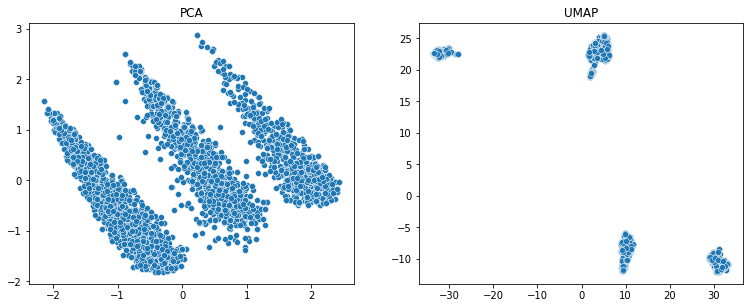

In [38]:
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

It looks like there may be 3 to 4 clusters.  

# Kmeans

The elbow occurs at 10


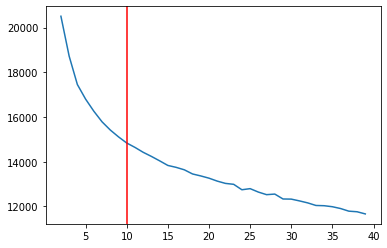

In [39]:
inertia_values = []
for n in range(2,40):
    kmeans = KMeans(n_clusters=n, random_state=625+n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
kl = KneeLocator(x=results[0],y=results[1],direction='decreasing',curve='convex')
elbow = kl.elbow
print('The elbow occurs at',elbow)

sns.lineplot(x=results[0],y=results[1])
plt.axvline(x=elbow, ymin=0, ymax = max(results[1]), color='red')

The elbow isn't apparent however Kneed calculates the elbow at 10

In [40]:
kmeans = KMeans(n_clusters=10, random_state=625)
preds = kmeans.fit_predict(X)
print("The silhouette score for 10 clusters is {}".format(silhouette_score(X,preds)))

The silhouette score for 10 clusters is 0.10283114481581261


The silouette score seems low, meaning clusters are mixing.  Below is a visualization.

<AxesSubplot:>

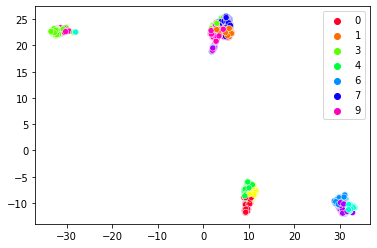

In [41]:
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')

As you can see the clusters are mixed together.  Going to try dbscan.

# DBSCAN

In [42]:
df_depressed_core.shape[1]

36

DBSCAN has two main parameters, eps and min samples.  According to the Analytics Vidhya blog post, min samples should be at least one more than the number of parameters.  Other blogs suggest two times the number of parameters.  I am going to try values in the range of 37 to 80 in incriments of 3.  Next I need to find the best epsilon values for these min samples.  From the same article, the best epsilon is found using the K_neighbors_graph.  The medium article shows how to plot the k_neighbors graph to determine eps. 

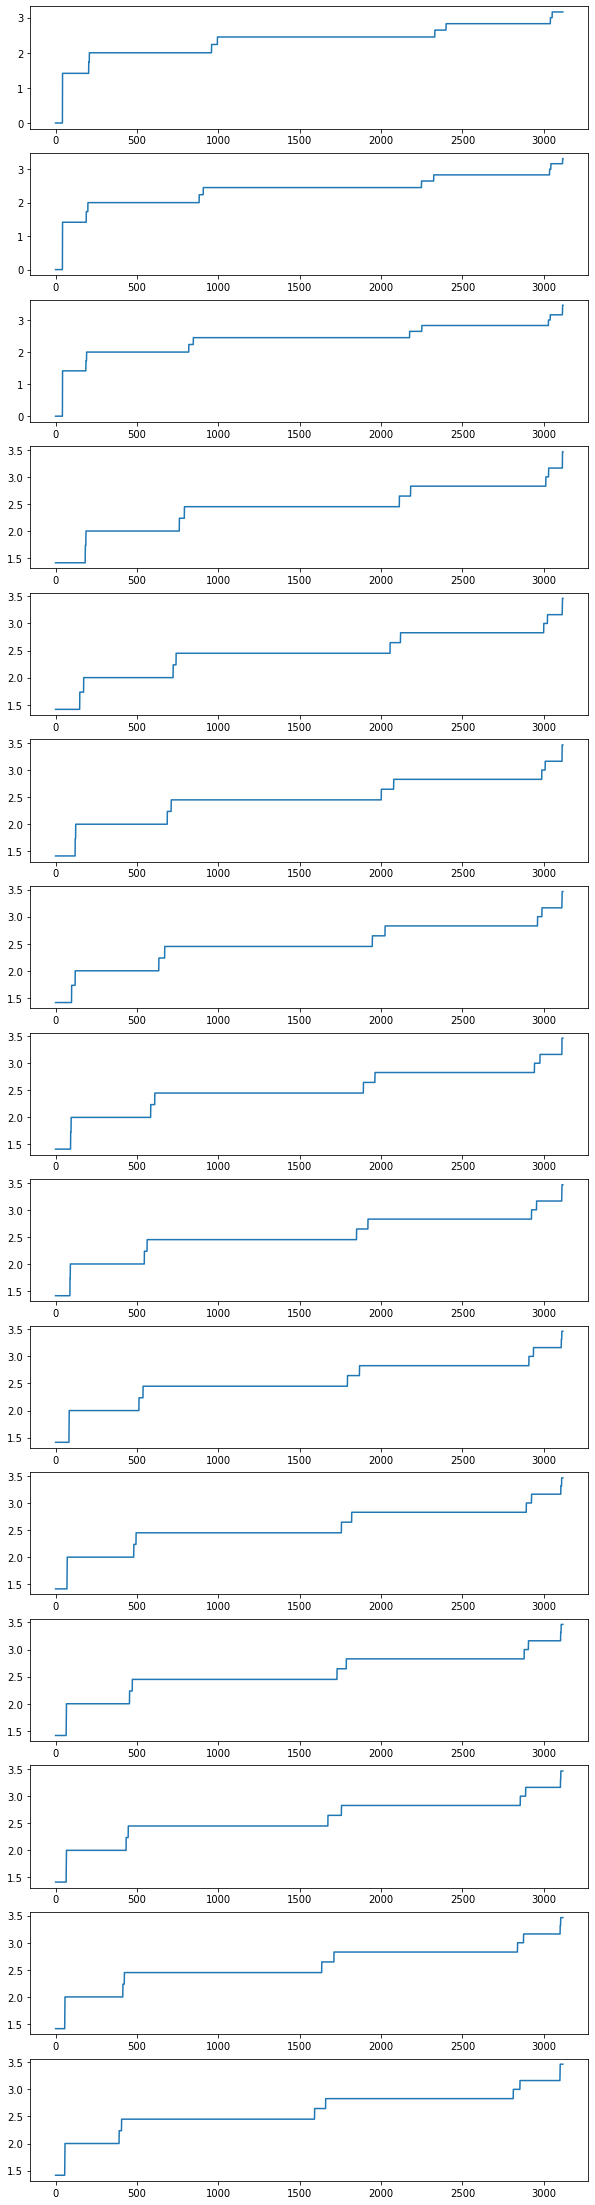

In [43]:
fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(10,40))
i = 0
for k in range(37,80,3):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k-1]
    axs[i].plot(distances)
    i+=1
    
    

As each graph looks similar, I am going to plot for 20 neighbors and increase the plot size

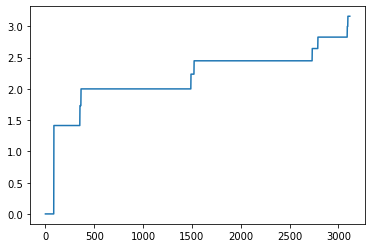

In [44]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,19]
plt.plot(distances)

For each of these there are many knee points.  Going to try a knee of 1.5, 2, 2.5, 2.75 then find which min samples produces the best silhouette score.  Finally adjust eps to find the best eps.

In [45]:
max_silhouette = 0
for eps in [1.5,2,2.5,2.75]:
    for min_samples in range(37,250,4):
        db = DBSCAN(eps=eps, min_samples = min_samples)
        preds = db.fit_predict(X)
        try:
            ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
            if ss > max_silhouette:
                max_silhouette = ss
                best_eps = eps
                best_min_samples = min_samples
        except:
            pass
print("The best eps is {} and the best min_samples is {}".format(best_eps, best_min_samples))


The best eps is 1.5 and the best min_samples is 77


With 77 as the best min_samples, I am going to try eps around 1.5

Going to now try to find the best eps with min_samples = 82

In [46]:
max_silhouette = 0
for eps in np.linspace(1.25, 1.75,26):
    db = DBSCAN(eps=eps, min_samples=77)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        if ss > max_silhouette:
            max_silhouette = ss
            best_eps = eps
        print("The silhouette score for eps {} is {}".format(eps,ss))
    except:
        pass

print("The best eps is {}".format(best_eps))

The silhouette score for eps 1.43 is 0.724711458473406
The silhouette score for eps 1.45 is 0.724711458473406
The silhouette score for eps 1.47 is 0.724711458473406
The silhouette score for eps 1.49 is 0.724711458473406
The silhouette score for eps 1.51 is 0.724711458473406
The silhouette score for eps 1.53 is 0.724711458473406
The silhouette score for eps 1.55 is 0.724711458473406
The silhouette score for eps 1.57 is 0.724711458473406
The silhouette score for eps 1.59 is 0.724711458473406
The silhouette score for eps 1.6099999999999999 is 0.724711458473406
The silhouette score for eps 1.63 is 0.724711458473406
The silhouette score for eps 1.65 is 0.724711458473406
The silhouette score for eps 1.67 is 0.724711458473406
The silhouette score for eps 1.69 is 0.724711458473406
The silhouette score for eps 1.71 is 0.724711458473406
The silhouette score for eps 1.73 is 0.724711458473406
The silhouette score for eps 1.75 is 0.7102779542881394
The best eps is 1.43


None of these made a difference.  Going to keep 1.5 as eps and 82 as min samples

In [47]:
db = DBSCAN(eps = 1.5, min_samples = 77)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 2


In [48]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2940,   95,   83], dtype=int64))

In [49]:
print("The silhouette score for DBSCAN is {}".format(silhouette_score(X[preds!=-1],preds[preds!=-1])))

The silhouette score for DBSCAN is 0.724711458473406


The silhouette score is high for two clusters.  
According to this paper, the amount of noise should be between 1 and 30 percent.  Here the amount of noice is over 90 percent.  Both Kmeans and Dbscan did not produce good clusters.  To try to improve the clusters, I am going to add more information to the data.  
  
Depression effects women more than men.  So first I am adding general demographics.

# Looking at demographics

In [50]:
demographics = ['AGEP_A','SEX_A','MARITAL_A', 'FAMINCTC_A','EDUC_A','EMPWRKLSWK_A','RACEALLP_A','HISP_A']
depressed_demo = df_depressed[demographics].copy()

AGEP_A contains the age of the adult individual.

<AxesSubplot:>

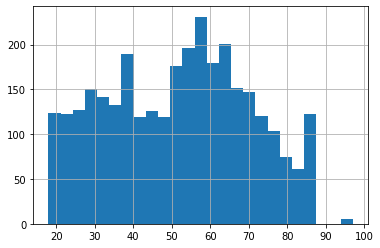

In [51]:
depressed_demo.AGEP_A.hist(bins=25)

From the histogram you can see adults of all ages struggle with depression.  The peaks are right before 40 and between 50 and 65.

SEX_A contains the gender of the adult.

<AxesSubplot:xlabel='SEX_A', ylabel='count'>

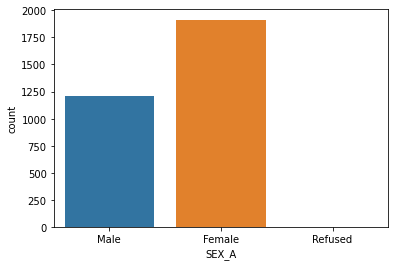

In [52]:
labels = {1:'Male',2:'Female',7:'Refused',8:'Not Ascertained',9:"Don't Know"}
depressed_demo.SEX_A.replace(labels,inplace=True)
sns.countplot(x='SEX_A',data=depressed_demo)

Notice there are more females than males.

MARITAL_A lists the marital status of the adult.

<AxesSubplot:xlabel='MARITAL_A', ylabel='count'>

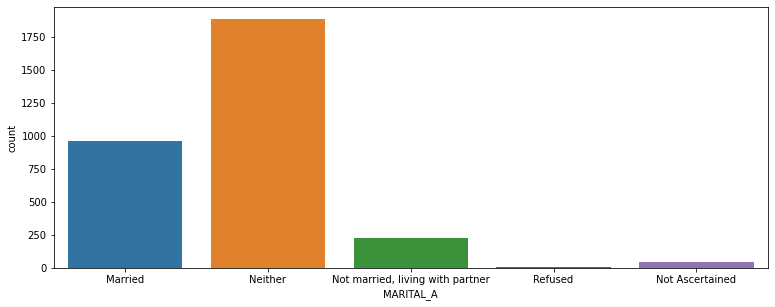

In [53]:
labels = {1:'Married',2:'Not married, living with partner',3:'Neither',7:'Refused',8:'Not Ascertained',9:"Don't Know"}
depressed_demo.MARITAL_A.replace(labels,inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='MARITAL_A',data=depressed_demo)

Most are not married and not living with a partner.

Going to combine refuesd and not ascertained into an other column.

In [54]:
labels = {'Refused':'Other','Not Ascertained':'Other'}
depressed_demo.MARITAL_A.replace(labels,inplace=True)

FAMINCTC_A has the family income.

<AxesSubplot:>

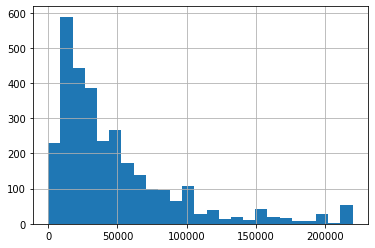

In [55]:
depressed_demo.FAMINCTC_A.hist(bins=25)

Most of those depressed have lower income.

EDUC_A has the education level of the adult.

<AxesSubplot:xlabel='count', ylabel='EDUC_A'>

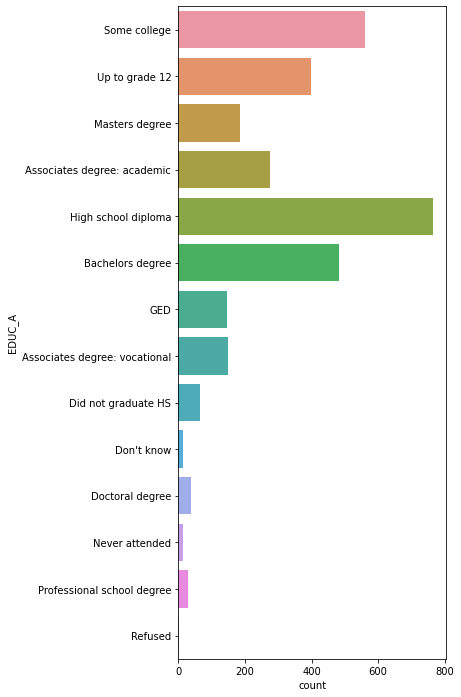

In [56]:
labels = {0:'Never attended',1:'Up to grade 12',2:'Did not graduate HS',3:'GED',4:'High school diploma',5:'Some college',
          6:'Associates degree: vocational',7:'Associates degree: academic',8:'Bachelors degree',9:'Masters degree',
         10:'Professional school degree',11:'Doctoral degree',97:'Refused',98:'Not ascertained',99:"Don't know"}

depressed_demo.EDUC_A.replace(labels,inplace=True)
plt.figure(figsize=(4.8, 12))
sns.countplot(y='EDUC_A',data=depressed_demo)

For those with depression, the most have a high school diploma.  Since there are many woth few counts, I am going to combine some buckets.

In [57]:
labels = {'Refused':'Other','Never attended':'Other',"Don't know":'Other','Masters degree':'Graduate school complete',
         'Professional school degree':'Graduate school complete','Doctoral degree':'Graduate school complete',
         'Did not graduate HS':'Up to grade 12','Associates degree: academic':'Associates degree',
         'Associates degree: vocational':'Associates degree','GED':'High school diploma'}
depressed_demo.EDUC_A.replace(labels,inplace=True)

In [58]:
depressed_demo.EDUC_A.unique()

array(['Some college', 'Up to grade 12', 'Graduate school complete',
       'Associates degree', 'High school diploma', 'Bachelors degree',
       'Other'], dtype=object)

In [59]:
depressed_demo.EMPWRKLSWK_A.unique()

array([1, 2, 9], dtype=int64)

EMPWRKLSWK_A denotes whether the adult worked last week.  With 1, yes, 2, no, and 9: don't know.

<AxesSubplot:xlabel='EMPWRKLSWK_A', ylabel='count'>

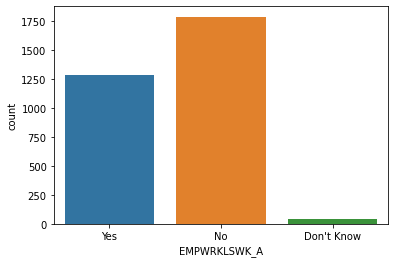

In [60]:
labels = {1:'Yes',2:'No',9:"Don't Know"}
depressed_demo.EMPWRKLSWK_A.replace(labels,inplace=True)
sns.countplot(x='EMPWRKLSWK_A',data=depressed_demo)

For those depressed, most did not work the past week.  I am going to replace yes with 1, no with -1 and don't know with 0

In [61]:
labels = {'Yes':1,'No':-1,"Don't Know":0}
depressed_demo.EMPWRKLSWK_A.replace(labels,inplace=True)

RACEALLP_A denotes single and multiple race groups.

In [62]:
depressed_demo.RACEALLP_A.unique()

array([1, 2, 5, 8, 3, 4, 6], dtype=int64)

1: White only
2: Black/African American only
3: Asian only
4: American indian only
5: American indian and any other group
6: Other single and multiple races
8: Not ascertained

<AxesSubplot:xlabel='count', ylabel='RACEALLP_A'>

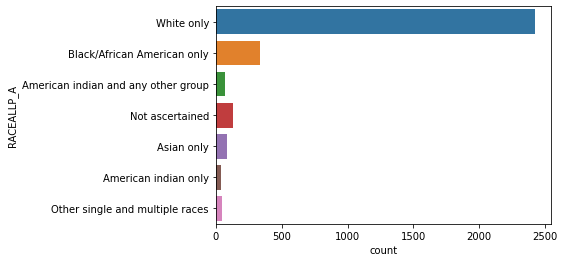

In [63]:
labels = {1: 'White only', 2: 'Black/African American only', 3: 'Asian only', 4: 'American indian only', 
          5: 'American indian and any other group', 6: 'Other single and multiple races', 8: 'Not ascertained'}
depressed_demo.RACEALLP_A.replace(labels, inplace=True)
sns.countplot(y='RACEALLP_A',data=depressed_demo)

For those with depression, the most are white.  However 75% of the respondents were white so nothing can be inferred.  I'm going tp combine the two american indian as well as other races and not ascertained.  Because the majority is white, Iam going to drop this variable.

In [64]:
depressed_demo.drop('RACEALLP_A',axis=1, inplace=True)

HISP_A asks about hispanic ethnicity

In [65]:
depressed_demo.HISP_A.unique()

array([2, 1], dtype=int64)

1: Yes
2: No

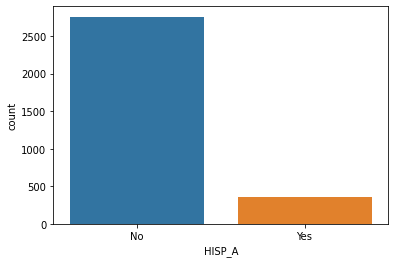

In [66]:
labels = {1:'Yes',2:'No'}
depressed_demo.HISP_A.replace(labels,inplace=True)
sns.countplot(x='HISP_A',data=depressed_demo)
labels={'Yes':1,'No':-1}
depressed_demo.HISP_A.replace(labels,inplace=True)

The majority of those with depression are not Hispanic.
Again I am going to drop this variable.

In [67]:
depressed_demo.drop('HISP_A',axis=1, inplace=True)

Standardizing the two non-ordinal variables...

In [68]:
# should I minmaxscaler all?
depressed_demo2 = depressed_demo.copy()
depressed_demo.FAMINCTC_A = (depressed_demo.FAMINCTC_A - depressed_demo.FAMINCTC_A.mean())/depressed_demo.FAMINCTC_A.std()
depressed_demo.AGEP_A = (depressed_demo.AGEP_A-depressed_demo.AGEP_A.mean())/depressed_demo.AGEP_A.std()


In [69]:
df_depressed_demo = pd.get_dummies(depressed_demo)

In [70]:
df_depressed_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   AGEP_A                                      3118 non-null   float64
 1   FAMINCTC_A                                  3118 non-null   float64
 2   EMPWRKLSWK_A                                3118 non-null   int64  
 3   SEX_A_Female                                3118 non-null   uint8  
 4   SEX_A_Male                                  3118 non-null   uint8  
 5   SEX_A_Refused                               3118 non-null   uint8  
 6   MARITAL_A_Married                           3118 non-null   uint8  
 7   MARITAL_A_Neither                           3118 non-null   uint8  
 8   MARITAL_A_Not married, living with partner  3118 non-null   uint8  
 9   MARITAL_A_Other                             3118 non-null   uint8  
 10  EDUC_A_Asso

Looking for high correlation

<AxesSubplot:>

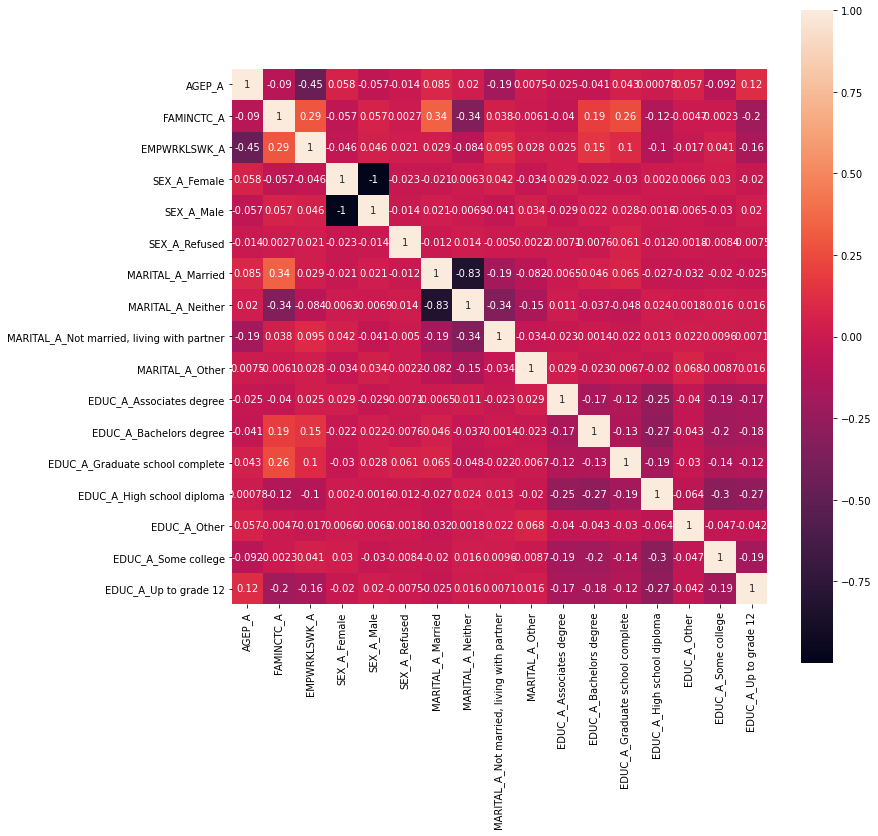

In [71]:
plt.figure(figsize=(12, 12))
sns.heatmap(df_depressed_demo.corr(),square=True,annot=True)

There does not appear to be any corrleation

Visualizing the data and doing KNN.



Text(0.5, 1.0, 'UMAP')

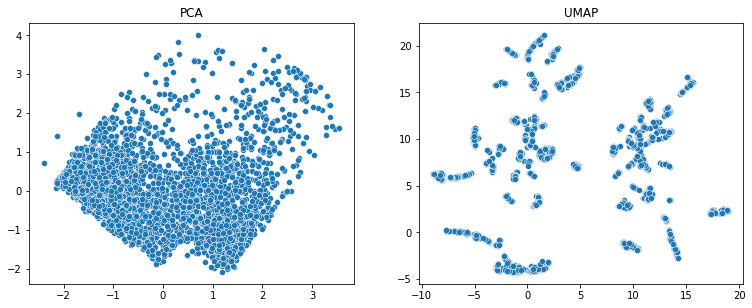

In [72]:
X = df_depressed_demo.values
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

There appears to be some clustering although with PCA it appears mixed.

The elbow occurs at 10


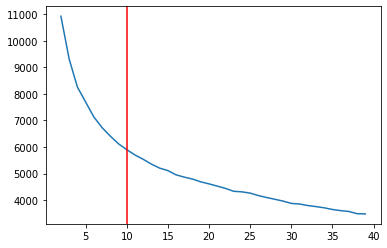

In [73]:
inertia_values = []
for n in range(2,40):
    kmeans = KMeans(n_clusters=n, random_state=625+n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
kl = KneeLocator(x=results[0],y=results[1],direction='decreasing',curve='convex')
elbow = kl.elbow
print('The elbow occurs at',elbow)

sns.lineplot(x=results[0],y=results[1])
plt.axvline(x=elbow, ymin=0, ymax = max(results[1]), color='red')

There is no clear elbow.  However kneed says the elbow is at 10.

In [74]:
kmeans = KMeans(n_clusters=10, random_state=625)
preds = kmeans.fit_predict(X)
print("The silhouette score for 10 clusters is {}".format(silhouette_score(X,preds)))

The silhouette score for 10 clusters is 0.18864153864041458


The silhouette score is low, showing there is mixing of clusters.

<AxesSubplot:>

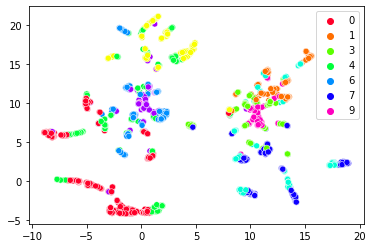

In [75]:
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')

As you can see clusters appear mixed.

Trying DBSCAN...

In [76]:
df_depressed_demo.shape[1]

17

With 17 features the value for min_samples should be at least 18.  I'm going to try min_samples from 18 to 47 in increments of 2.

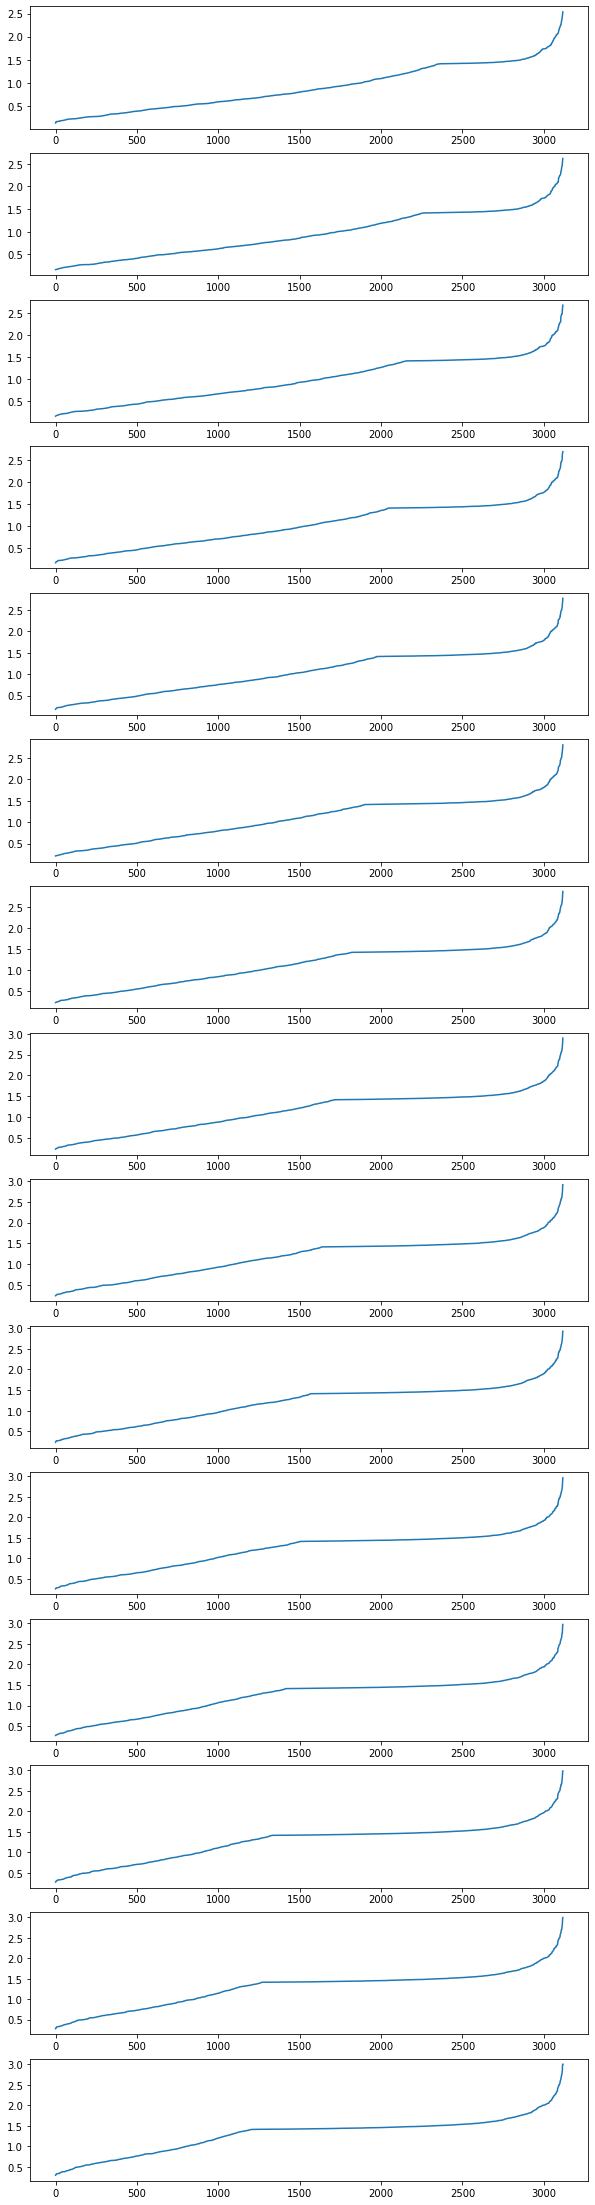

In [77]:
fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(10,40))
i = 0
for k in range(18,47,2):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k-1]
    axs[i].plot(distances)
    i+=1

Since all look similar, I'm going to try minsamples of 25

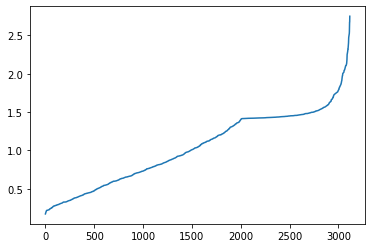

In [78]:
neighbors = NearestNeighbors(n_neighbors=25)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,24]
plt.plot(distances)

The turn point looks approximately at 1.5.  I am going to use kneed to find the other one

In [79]:
max_silhouette = 0
for min_samples in range(18,80,2):
    db = DBSCAN(eps=1.5, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        if ss > max_silhouette:
            max_silhouette = ss
            best_min_samples = min_samples
    except:
        pass
print("The best min_samples is {}".format(best_min_samples))


The best min_samples is 77


By silhouette score the best min_samples is 77

In [80]:
max_silhouette = 0
for eps in np.linspace(1.25, 1.75,26):
    db = DBSCAN(eps=eps, min_samples=77)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        if ss > max_silhouette:
            max_silhouette = ss
            best_eps = eps
        print("The silhouette score for eps {} is {}".format(eps,ss))
    except:
        pass

print("The best eps is {}".format(best_eps))

The silhouette score for eps 1.25 is 0.38703490573697064
The silhouette score for eps 1.27 is 0.38218321297836794
The silhouette score for eps 1.29 is 0.3795794788670478
The silhouette score for eps 1.31 is 0.3789027953727821
The silhouette score for eps 1.33 is 0.3759845939794115
The silhouette score for eps 1.35 is 0.3751854873609795
The silhouette score for eps 1.37 is 0.3714604686127069
The silhouette score for eps 1.3900000000000001 is 0.37107748867534296
The silhouette score for eps 1.41 is 0.37154747623051704
The silhouette score for eps 1.43 is 0.3223921999122126
The silhouette score for eps 1.45 is 0.30427310719700656
The silhouette score for eps 1.47 is 0.2941744454814442
The best eps is 1.25


Choosing min_samples as 77 and eps as 1.25

In [81]:
db = DBSCAN(eps = 1.25, min_samples = 77)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 8


In [82]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64),
 array([2133,  116,  139,  109,  144,  234,   89,   77,   77], dtype=int64))

There are fewer outliers than depressed_core but still the majority are outliers.

In [83]:
print("The silhouette score for DBSCAN is {}".format(silhouette_score(X[preds!=-1],preds[preds!=-1])))

The silhouette score for DBSCAN is 0.38703490573697064


The silhouette score is high, but not as high as with depressed_core.

Next I am going to combine the two datasets and see what kmeans and dbscan bring.

In [84]:
df_depressed_democore = pd.concat([df_depressed_demo,df_depressed_core],axis=1)

In [85]:
df_depressed_democore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   AGEP_A                                      3118 non-null   float64
 1   FAMINCTC_A                                  3118 non-null   float64
 2   EMPWRKLSWK_A                                3118 non-null   int64  
 3   SEX_A_Female                                3118 non-null   uint8  
 4   SEX_A_Male                                  3118 non-null   uint8  
 5   SEX_A_Refused                               3118 non-null   uint8  
 6   MARITAL_A_Married                           3118 non-null   uint8  
 7   MARITAL_A_Neither                           3118 non-null   uint8  
 8   MARITAL_A_Not married, living with partner  3118 non-null   uint8  
 9   MARITAL_A_Other                             3118 non-null   uint8  
 10  EDUC_A_Asso

# Visualizing the dataset

In [86]:
X = df_depressed_democore.values

Text(0.5, 1.0, 'UMAP')

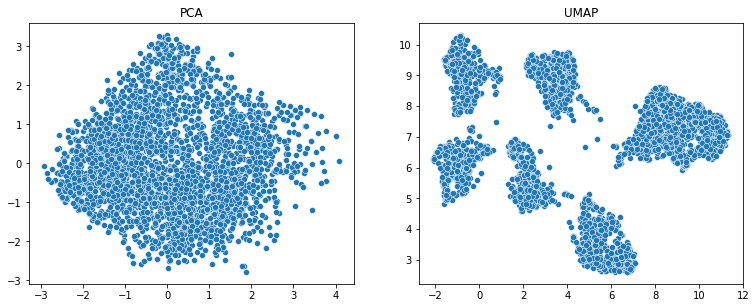

In [87]:
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

PCA appears dense, there may be 2 clusters, while UMAP shows 4 or more possible clusters.  Although a lot of information is lost as you are going from 53 features to 2.  Trying kmeans...

The elbow occurs at 11


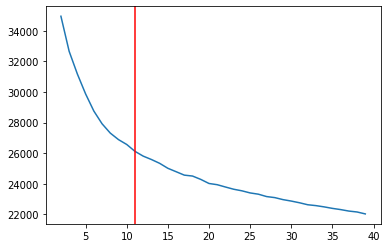

In [88]:
inertia_values = []
for n in range(2,40):
    kmeans = KMeans(n_clusters=n, random_state=625+n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
kl = KneeLocator(x=results[0],y=results[1],direction='decreasing',curve='convex')
elbow = kl.elbow
print('The elbow occurs at',elbow)

sns.lineplot(x=results[0],y=results[1])
plt.axvline(x=elbow, ymin=0, ymax = max(results[1]), color='red')

Again there is no apparent elbow, KNEED calculates the elbow to be at 11.

In [89]:
kmeans = KMeans(n_clusters=11, random_state=625)
preds = kmeans.fit_predict(X)
print("The silhouette score for 10 clusters is {}".format(silhouette_score(X,preds)))

The silhouette score for 10 clusters is 0.07553099313528648


The silhouette score is low.  There is apparent mixing of clusters.

<AxesSubplot:>

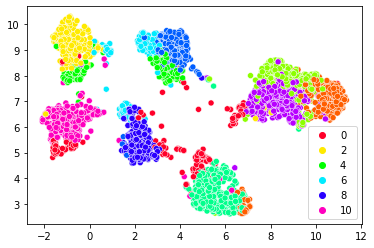

In [90]:
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')

Trying DBSCAN...

In [91]:
df_depressed_democore.shape[1]

53

With 53 features, the min_samples shoud be at least 54.  Going to try to find the best eps using values from 54 to 130 in increments of 4.

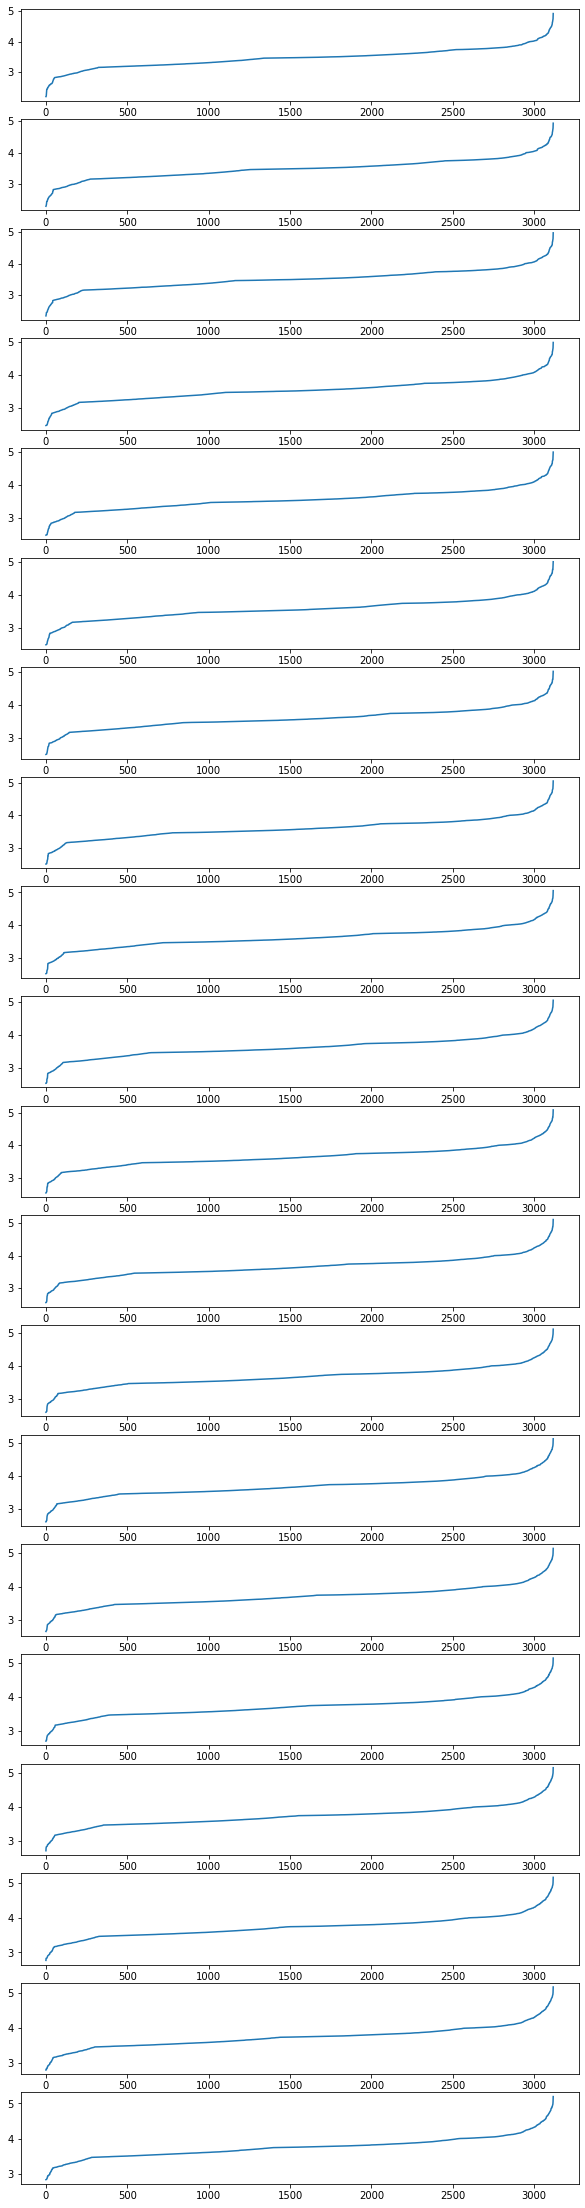

In [92]:
fig, axs = plt.subplots(nrows=20, ncols=1, figsize=(10,40))
i = 0
for k in range(54,131,4):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k-1]
    axs[i].plot(distances)
    i+=1

There are multiple turn points, one at 3, one at about 3.25, and one at about 4.

In [93]:
max_silhouette = 0
for eps in [3,3.25,4]:
    for min_samples in range(54,250,4):
        db = DBSCAN(eps=eps, min_samples = min_samples)
        preds = db.fit_predict(X)
        try:
            ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
            if ss > max_silhouette:
                max_silhouette = ss
                best_eps = eps
                best_min_samples = min_samples
        except:
            pass
print("The best eps is {} and the best min_samples is {}".format(best_eps, best_min_samples))


The best eps is 3 and the best min_samples is 94


Here the best min samples is 94 with an epsilon of 3.

In [94]:
max_silhouette = 0
for eps in np.linspace(2.75, 3.25,51):
    db = DBSCAN(eps=eps, min_samples=94)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        if ss > max_silhouette:
            max_silhouette = ss
            best_eps = eps
    except:
        pass

print("The best eps is {}".format(best_eps))

The best eps is 2.96


With min_samples of 94, the best eps is 2.96

In [95]:
db = DBSCAN(eps = 2.96, min_samples = 94)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 2


In [96]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2648,  376,   94], dtype=int64))

Still the vast majority are classified as outliers.

In [97]:
print("The silhouette score for DBSCAN is {}".format(silhouette_score(X[preds!=-1],preds[preds!=-1])))

The silhouette score for DBSCAN is 0.3142936272046033


The silhouette score isn't bad, but there are many outliers.

<AxesSubplot:>

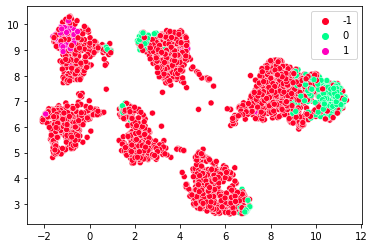

In [98]:
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')


The NHIS survey also contains information on substance absuse.  I'm going to add that next to see if I can cluster the data.

# Looking at substance abuse

In [99]:
substances = ['OPD12M_A','SMKNOW_A','ECIGNOW_A']
df_substances = df_depressed[substances].copy()

In [100]:
df_substances.isnull().sum()

OPD12M_A      452
SMKNOW_A     1481
ECIGNOW_A    2310
dtype: int64

In [101]:
df_depressed.shape[0]

3118

Over a third of the dataset is null for smoking and electronic cigarettes.  I'm going to skip including substance abuse.

Next I'm going to look at chronic conditions

# Looking at Chronic Conditions

In [102]:
# diabetes may be null, might want to use PREDIB_A
conditions = ['HYPEV_A','CHLEV_A','ASEV_A','CANEV_A','DIBEV_A','COPDEV_A']
df_conditions = df_depressed[conditions].copy()
df_conditions.isnull().sum()

HYPEV_A     0
CHLEV_A     0
ASEV_A      0
CANEV_A     0
DIBEV_A     0
COPDEV_A    0
dtype: int64

HYPEV_A asks if you have ever been told you have hypertension. The respnses are 1: yes, 2: no, 7: refused, 8: not ascertained and 9: don't know.

<AxesSubplot:xlabel='HYPEV_A', ylabel='count'>

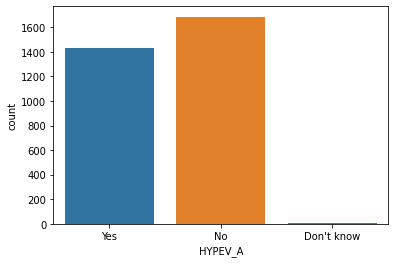

In [103]:
labels_yn = {1: 'Yes', 2: "No", 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
df_conditions.HYPEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='HYPEV_A', data=df_conditions)

Goint to replace yes with 1, no wth -1 and don't know with 0

In [104]:
labels_yn_r = {'Yes':1,'No':-1,"Don't know":0,"Refused":0, "Not ascertained" : 0}
df_conditions.HYPEV_A.replace(labels_yn_r, inplace=True)

CHLEV_A asks if the adult has ever had high cholesterol.

<AxesSubplot:xlabel='CHLEV_A', ylabel='count'>

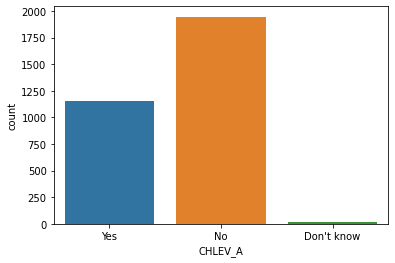

In [105]:
df_conditions.CHLEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='CHLEV_A', data=df_conditions)

In [106]:
df_conditions.CHLEV_A.replace(labels_yn_r, inplace=True)

ASEV_A asks if you have ever been told by a doctor you have asthma

<AxesSubplot:xlabel='ASEV_A', ylabel='count'>

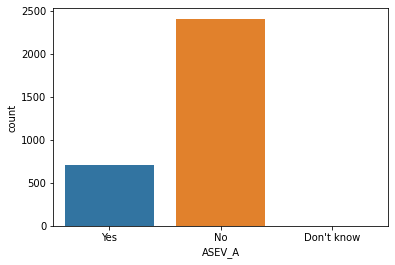

In [107]:
df_conditions.ASEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='ASEV_A', data=df_conditions)


In [108]:
df_conditions.ASEV_A.replace(labels_yn_r, inplace=True)

CANEV_A asks if you have ever been told you have cancer.

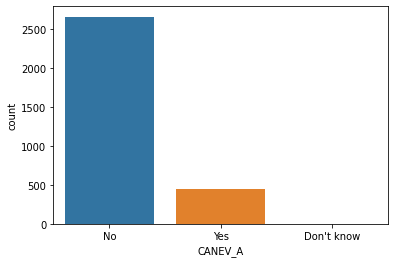

In [109]:
df_conditions.CANEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='CANEV_A', data=df_conditions)
df_conditions.CANEV_A.replace(labels_yn_r, inplace=True)

DIBEV_A asks if you have ever been told by a doctor you have diabetes.

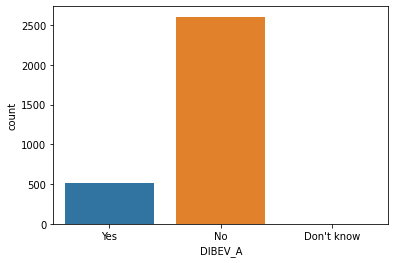

In [110]:
df_conditions.DIBEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='DIBEV_A', data=df_conditions)
df_conditions.DIBEV_A.replace(labels_yn_r, inplace=True)


COPDEV_A asks if you have ever been told by a doctor you have COPD, emphysema, or chronic bronchitis.

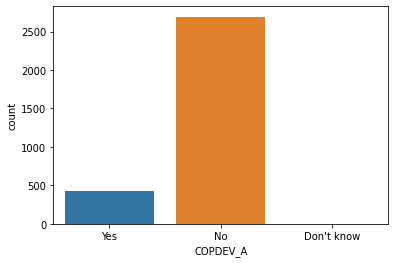

In [111]:
df_conditions.COPDEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='COPDEV_A', data=df_conditions)
df_conditions.COPDEV_A.replace(labels_yn_r, inplace=True)

Checking correlation

<AxesSubplot:>

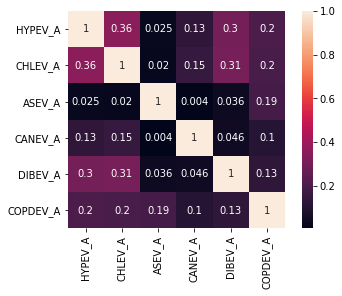

In [112]:
sns.heatmap(df_conditions.corr(),square=True,annot=True)

There doesn't appear to be any correlation.  Using PCA and UMAP to visualize the data..

Text(0.5, 1.0, 'UMAP')

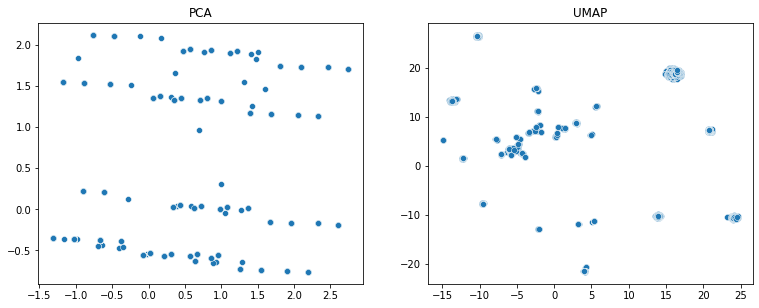

In [113]:
X = df_conditions.values
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

Both images show clustering of data.

The elbow occurs at 11


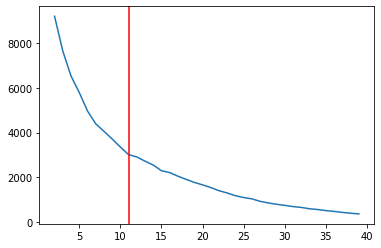

In [114]:
inertia_values = []
for n in range(2,40):
    kmeans = KMeans(n_clusters=n, random_state=625+n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
kl = KneeLocator(x=results[0],y=results[1],direction='decreasing',curve='convex')
elbow = kl.elbow
print('The elbow occurs at',elbow)

sns.lineplot(x=results[0],y=results[1])
plt.axvline(x=elbow, ymin=0, ymax = max(results[1]), color='red')

Kneed says the knee is at 11.

In [115]:
kmeans = KMeans(n_clusters=11, random_state=625)
preds = kmeans.fit_predict(X)
print("The silhouette score for 11 clusters is {}".format(silhouette_score(X,preds)))

The silhouette score for 11 clusters is 0.6270060178042232


That silhouette score is high, clusters are more divided than others we have seen already.

<AxesSubplot:>

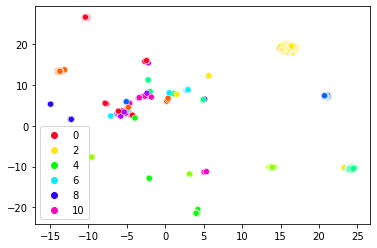

In [116]:
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')

There is seperation of most clusters.

Using dbscan

In [117]:
df_conditions.shape[1]

6

Given only 6 features, the min samples should be 7 or more.  Going to try values from 7 to 15.  First, I am going to look at the kneighbors plot for min_samples of 10

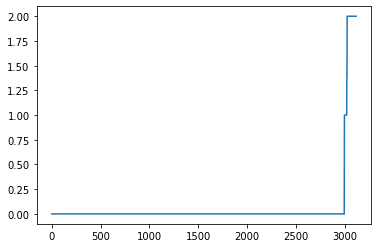

In [118]:
X = df_conditions.values
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,9]
plt.plot(distances)


Definitely a low value of eps, probably 0.05

In [119]:
for min_samples in range(7,16):
    db = DBSCAN(eps=0.05, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass

The silhouette score for min_samples of 7 is 1.0
The silhouette score for min_samples of 8 is 1.0
The silhouette score for min_samples of 9 is 1.0
The silhouette score for min_samples of 10 is 1.0
The silhouette score for min_samples of 11 is 1.0
The silhouette score for min_samples of 12 is 1.0
The silhouette score for min_samples of 13 is 1.0
The silhouette score for min_samples of 14 is 1.0
The silhouette score for min_samples of 15 is 1.0


With all perfect silhouette scores, I'm assuming many outliers.   First I'll try with min_samples 15 and eps 0.05, then I'll increase the eps.

In [120]:
db = DBSCAN(eps = 0.05, min_samples = 15)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))
print('cluster sizes: ',np.unique(preds, return_counts=True))


The number of clusters selected by DBSCAN is 31
cluster sizes:  (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype=int64), array([220,  34, 897, 298,  15, 178, 224,  35, 144,  34,  72,  17,  76,
        48,  41, 239,  72,  33,  25,  26,  49,  16,  30,  53,  29,  17,
        54,  37,  22,  32,  33,  18], dtype=int64))


There are definitely many clusters and few outliers.  This is definitely a good clustering.  And it has a silhouette score of 1 so each is identical, in respect to chronic conditions.

In [121]:
silhouette_score(X[preds!=-1],preds[preds!=-1])

1.0

The silhouette score is perfect. There is clustering based on chronic conditions.  However since this doesn't include depression variables, it may just be clustering chronic conditions.  Going to concat depressed_core with df_conditions

<AxesSubplot:>

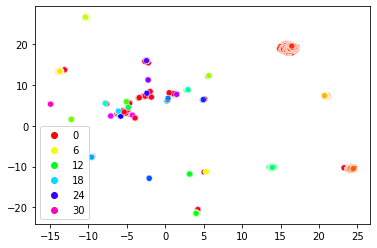

In [122]:

sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')

In [123]:
df_core_conditions = pd.concat([df_depressed_core,df_conditions], axis=1)

Text(0.5, 1.0, 'UMAP')

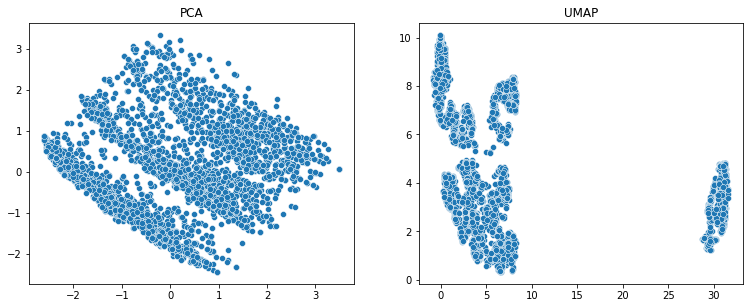

In [124]:
X = df_core_conditions.values
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

Here also there appears to be clustering.

The elbow occurs at 12


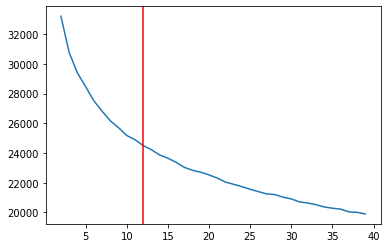

In [125]:
inertia_values = []
for n in range(2,40):
    kmeans = KMeans(n_clusters=n, random_state=625+n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
kl = KneeLocator(x=results[0],y=results[1],direction='decreasing',curve='convex')
elbow = kl.elbow
print('The elbow occurs at',elbow)

sns.lineplot(x=results[0],y=results[1])
plt.axvline(x=elbow, ymin=0, ymax = max(results[1]), color='red')

The elbow is not very pronounced.  Kneed predicts it to be at 12.

In [126]:
kmeans = KMeans(n_clusters=12, random_state=625)
preds = kmeans.fit_predict(X)
print("The silhouette score for 11 clusters is {}".format(silhouette_score(X,preds)))

The silhouette score for 11 clusters is 0.08088584212962809


Combining depressed core and chronic conditions drops the silhouette values.  

Trying dbscan...

In [127]:
df_core_conditions.shape[1]

42

Since there are 42 features, the min samples must be at least 52.  Going to look at the kneighbors plot for 70 samples.

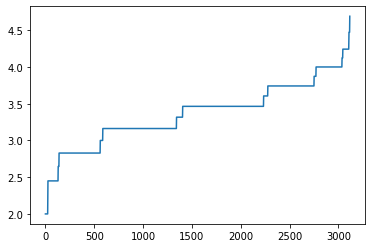

In [128]:
neighbors = NearestNeighbors(n_neighbors=70)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,69]
plt.plot(distances)

Again there are multiple turn points going to try from 2.5 to 4.25 in increments of 0.25

In [129]:
max_silhouette = 0
for eps in [2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25]:
    for min_samples in range(43,250,4):
        db = DBSCAN(eps=eps, min_samples = min_samples)
        preds = db.fit_predict(X)
        try:
            ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
            if ss > max_silhouette:
                max_silhouette = ss
                best_eps = eps
                best_min_samples = min_samples
        except:
            pass
print("The best eps is {} and the best min_samples is {}".format(best_eps, best_min_samples))

The best eps is 2.5 and the best min_samples is 71


The min samples with the best silhouette score is 71.  Going to use 71 and find the best eps.

In [130]:
max_silhouette = 0
for eps in np.linspace(2.25, 2.75,51):
    db = DBSCAN(eps=eps, min_samples=71)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        if ss > max_silhouette:
            max_silhouette = ss
            best_eps = eps
    except:
        pass

print("The best eps is {}".format(best_eps))

The best eps is 2.45


The best epsilon is at 2.45

In [131]:
db = DBSCAN(eps = 2.45, min_samples = 71)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 2


In [132]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2437,  605,   76], dtype=int64))

Notice there are a lot fewer outliers than seen before but there are still many.

In [133]:
silhouette_score(X[preds!=-1],preds[preds!=-1])

0.23048058635691154

# Hierarchal clustering of the combined data

Neither kmeans nor dbscan did well we combined the subsets of data for clustering.  I am now going to try hierarchial clustering.  Since there are over 3000 datapoints, a dendogram will not be very useful.  What I will do is use kmeans to get the clusters down to 20, then use a dendogram on the centroids to visualize which clusters are close together in order to chose the number of clusters.

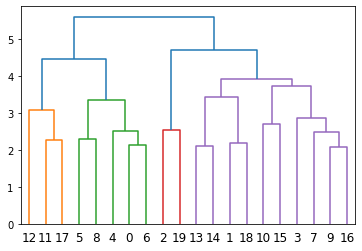

In [141]:
combined_data = pd.concat([df_depressed_core, df_depressed_demo, df_conditions], axis=1)
X = combined_data.values
kmeans = KMeans(n_clusters=20, random_state=625)
kmeans.fit(X)
X = kmeans.cluster_centers_
dendrogram(linkage(X, method='complete'))
plt.show()

None of the clusters appear close together by looking at the base of the dendogram.
Trying 8 clusters.

In [144]:
X = combined_data.values
pca = PCA(n_components=0.95,svd_solver = 'full')
X = pca.fit_transform(X)
agg = AgglomerativeClustering(n_clusters=8)
preds = agg.fit_predict(X)
silhouette_score(X,preds)

0.03750367440919411

Again the silhouette score is low

# Write down the silhouette scores, chose the best kmeans and the best dbscan to evaluate

In [135]:
X = df_conditions.values
db = DBSCAN(eps = 0.05, min_samples = 7)
cc_preds = db.fit_predict(X)
cc_clusters = cc_preds.max()+1

In [136]:
df_cluster_analysis = pd.concat([depressed_core,depressed_demo2,df_conditions],axis=1)

In [137]:
# need to figure out how not to include the float columns or just check that column later
labels = {1:'Yes',0:'Other',-1:'No'}
for col in df_cluster_analysis.columns:
    if df_cluster_analysis[col].dtype != "object" and col !='FAMINCTC_A' and col != 'AGEP_A':
        df_cluster_analysis[col].replace(labels,inplace=True)
df_cluster_analysis['cc_clusters']=cc_preds

In [138]:
df_cluster_analysis.head()

,DEPEV_A,DEPFREQ_A,DEPMED_A,DEPLEVEL_A,PHQ81_A,PHQ82_A,PHQ83_A,PHQ84_A,PHQ85_A,PHQ86_A,...,FAMINCTC_A,EDUC_A,EMPWRKLSWK_A,HYPEV_A,CHLEV_A,ASEV_A,CANEV_A,DIBEV_A,COPDEV_A,cc_clusters
4,Yes,Daily,Yes,Somewhere in between,Nearly every day,More than half the days,Several days,More than half the days,Several days,Several days,...,30000,Some college,Yes,Yes,Yes,Yes,No,Yes,Yes,0
28,No,Weekly,No,Somewhere in between,Not at all,More than half the days,More than half the days,Not at all,Several days,More than half the days,...,60000,Up to grade 12,No,No,No,No,No,No,No,1
37,Yes,Daily,Yes,Somewhere in between,Not at all,More than half the days,Nearly every day,Several days,Not at all,Several days,...,52877,Some college,No,Yes,No,No,No,No,No,2
41,No,Weekly,No,Somewhere in between,Several days,More than half the days,Nearly every day,Nearly every day,Nearly every day,Nearly every day,...,20000,Some college,Yes,No,No,No,No,No,No,1
48,Yes,Daily,No,A little,Not at all,Several days,Not at all,Not at all,Several days,Not at all,...,9000,Some college,No,Yes,Yes,Yes,Yes,No,No,3
